# 데이터셋 디렉터리 구조 수정
## 현재
```pgsql
test/data/raw/   
├── TrainingSet/Closed/*.jpg  
├── TrainingSet/Opened/*.jpg  
├── TestSet/Closed/*.jpg  
├── TestSet/Opened/*.jpg   
├── ImprovementSet/Closed/*.jpg   
├── ImprovementSet/Opened/*.jpg   
```

In [1]:
!tree ../data/raw -L 2

../data/raw
├── ImprovementSet
│   ├── Closed
│   └── Opened
├── TestSet
│   ├── Closed
│   └── Opened
└── TrainingSet
    ├── Closed
    └── Opened

9 directories, 0 files


## 경로 수정 및 prefix 붙이기
> 중복 방지

In [2]:
import os
import shutil

In [3]:
RAW_ROOT="../data/raw"

TARGET_CLOSED=os.path.join(RAW_ROOT, "Closed")
TARGET_OPENED=os.path.join(RAW_ROOT, "Opened")
os.makedirs(TARGET_CLOSED, exist_ok=True)
os.makedirs(TARGET_OPENED, exist_ok=True)

sets=[("TrainingSet", "train"),
    ("TestSet", "test"),
    ("ImprovementSet", "imp")]

for set, prefix in sets:
    for state in ["Closed", "Opened"]:
        src_dir=os.path.join(RAW_ROOT, set, state)
        dst_dir=TARGET_CLOSED if state=="Closed" else TARGET_OPENED

        for file in os.listdir(src_dir):
            if file.lower().endswith(".jpg"):
                new_name=f"{prefix}_{file}"
                src_path=os.path.join(src_dir, file)
                dst_path=os.path.join(dst_dir, new_name)
                shutil.move(src_path, dst_path)

# 이동 후 빈 폴더 제거
for dirpath, dirnames, filenames in os.walk(RAW_ROOT, topdown=False):
    # 숨김 파일 제거
    for file in filenames:
        if file.startswith("."):
            os.remove(os.path.join(dirpath, file))
    # .ipynb_checkpoints 제거
    for dirname in dirnames:
        if dirname==".ipynb_checkpoints":
            shutil.rmtree(os.path.join(dirpath, dirname), ignore_errors=True)
    # 폴더 비었으면 삭제
    if not os.listdir(dirpath):
        os.rmdir(dirpath)

In [4]:
!tree ../data/raw -L 1

../data/raw
├── Closed
└── Opened

2 directories, 0 files


# 회색 배경 제거 + 살색 채우기 + 86x86 resize

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [8]:
RAW_ROOT="../data/raw"
PROCESSED_ROOT="../data/processed"
IMG_SIZE=86
GRAY_COLOR=np.array([98, 98, 98])  # color picker 기준 배경 회색 RGB
DIFF_CHECK_VALUE=5  # 허용 범위
TRIM=20

In [9]:
for cls in ["Closed", "Opened"]:
    input_dir=os.path.join(RAW_ROOT, cls)
    output_dir=os.path.join(PROCESSED_ROOT, cls)
    os.makedirs(output_dir, exist_ok=True)

    print(f"{cls} >>>")
    for file in tqdm(os.listdir(input_dir)):
        img_path=os.path.join(input_dir, file)
        save_path=os.path.join(output_dir, file)
        
        img=cv2.imread(img_path)
        img_rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 회색 배경 마스크
        diff=np.abs(img_rgb-GRAY_COLOR)
        gray_mask=np.all(diff<DIFF_CHECK_VALUE, axis=-1).astype(np.uint8)
        mask=(1-gray_mask).astype(np.uint8)

        # Trim 포함 bbox 계산
        nonzero_pts=cv2.findNonZero(mask)
        
        # 눈+피부가 있는 부분을 둘러싼 bbox 좌표와 크기
        x, y, w, h=cv2.boundingRect(nonzero_pts)
        x=x+TRIM  # bbox 좌상단 x좌표 + TRIM -> x좌표 안쪽으로 댕기기
        y=y+TRIM  # bbox 좌상단 y좌표 + TRIM -> y좌표 안쪽으로 댕기기
        w=w-TRIM*2  # bbox 너비 - TRIM*2 -> bbox 영역 줄이기
        h=h-TRIM*2  # bbox 높이 - TRIM*2 -> bbox 영역 줄이기
        
        # x, y는 이미지 밖 음수로 내려가지 않도록 0 이상으로 보정
        x=max(x, 0)
        y=max(y, 0)
        # w, h는 너무 작아져서 crop에 실패하거나 오류가 나지 않게 최소 10픽셀은 유지하게
        w=max(w, 10)
        h=max(h, 10)

        # 반드시 [세로 범위, 가로 범위] 순으로 슬라이싱
        cropped_img=img_rgb[y:y+h, x:x+w]
        cropped_mask=mask[y:y+h, x:x+w]

        # 살색처리
        bg_color=np.median(cropped_img[cropped_mask==1], axis=0).astype(np.uint8)
        filled=cropped_img.copy()
        filled[cropped_mask==0]=bg_color

        resized=cv2.resize(filled, (IMG_SIZE, IMG_SIZE))
        cv2.imwrite(save_path, cv2.cvtColor(resized, cv2.COLOR_RGB2BGR))

Closed >>>


100%|██████████| 5002/5002 [00:57<00:00, 86.90it/s]


Opened >>>


100%|██████████| 5037/5037 [00:56<00:00, 89.52it/s]


In [14]:
import random

PROCESSED_ROOT="../data/processed"
IMG_SIZE=86

def load_random_images(folder, count=5):
    files=os.listdir(folder)
    selected=random.sample(files, count)
    images=[]
    for file in selected:
        path=os.path.join(folder, file)
        img=cv2.imread(path)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append((img, file))
    return images

closed_imgs=load_random_images(os.path.join(PROCESSED_ROOT, "Closed"))
opened_imgs=load_random_images(os.path.join(PROCESSED_ROOT, "Opened"))

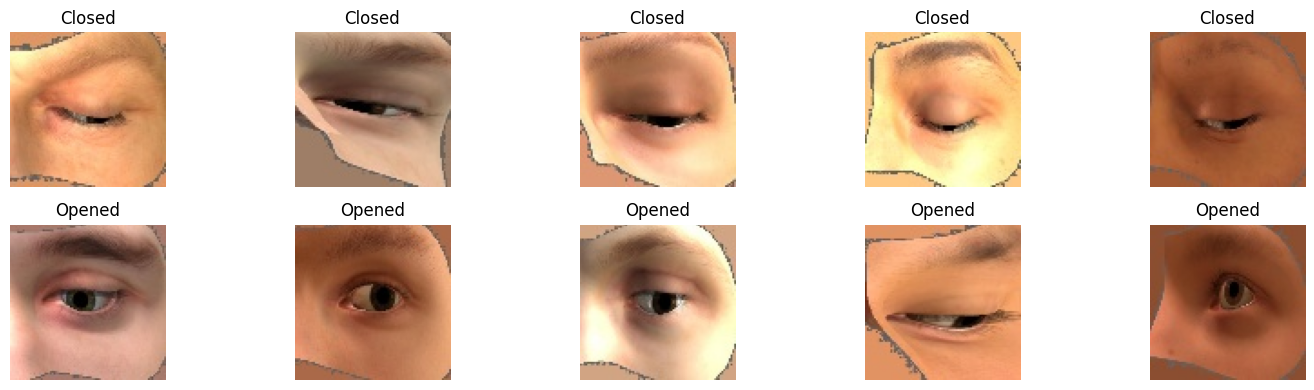

In [16]:
plt.figure(figsize=(15, 4))

for i, (img, file) in enumerate(closed_imgs + opened_imgs):
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title("Closed" if i < 5 else "Opened")
    plt.axis("off")

plt.tight_layout()
plt.show()

# 사전학습 모델을 위해 resize

In [17]:
import os
import cv2
from tqdm import tqdm

INPUT_DIR="../data/processed"
OUTPUT_DIR="../data/processed_224"
IMG_SIZE=224

for cls in ["Closed", "Opened"]:
    input_cls_path=os.path.join(INPUT_DIR, cls)
    output_cls_path=os.path.join(OUTPUT_DIR, cls)
    os.makedirs(output_cls_path, exist_ok=True)

    for fname in tqdm(os.listdir(input_cls_path), desc=cls):
        img_path=os.path.join(input_cls_path, fname)
        save_path=os.path.join(output_cls_path, fname)

        img=cv2.imread(img_path)
        if img is not None:
            resized=cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            cv2.imwrite(save_path, resized)

Opened: 100%|██████████| 5037/5037 [00:01<00:00, 3176.81it/s]
